In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import umap

import matplotlib.pyplot as plt
import matplotlib
 
import pickle as pk
import h5py

import scanpy as sc

# If you use the code in Github's folder VITAE instead of installing 
# via PyPI, then you need to add parent folder path to load our package
import sys; sys.path.insert(0, '..')
import VITAE
print(VITAE.__version__)
from VITAE import load_data, reset_random_seeds

2025-03-14 00:47:30.580263: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-14 00:47:30.598812: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-14 00:47:30.598828: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-14 00:47:30.599417: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-14 00:47:30.602445: I tensorflow/core/platform/cpu_feature_guar

2.1.0


# Load data

In this notebook, we illustrate how to infer trajectory on scATAC and scRNA data using our algorithm. We will use the following datasets:
- `human_hematopoiesis_scRNA`: gene experession data
- `human_hematopoiesis_scATAC`: gene score data calculated from scATAC data; see [rds_to_h5.R](https://github.com/jaydu1/VITAE/blob/master/paper/Application%20on%20scRNA%20and%20scATAC%20datasets/rds_to_h5.R) for details.

We have prepare these datasets in **hdf5** format, which can be easily loaded by the following codes:

In [2]:
adata_atac = load_data('../data', 'human_hematopoiesis_scATAC')
adata_rna = load_data('../data', 'human_hematopoiesis_scRNA')

celltype_exclude = ['CD4.M', 'CD4.N', 'CD8.CM', 'CD8.EM', 'CD8.N', 'NK', 'Plasma', 'cDC', 'CD16.Mono']
adata_atac = adata_atac[~np.isin(adata_atac.obs['grouping'], celltype_exclude),:]
adata_rna = adata_rna[~np.isin(adata_rna.obs['grouping'], celltype_exclude),:]
print(adata_atac, adata_rna)

View of AnnData object with n_obs × n_vars = 22685 × 15714
    obs: 'grouping', 'covariate_0'
    layers: 'count' View of AnnData object with n_obs × n_vars = 19309 × 15714
    obs: 'grouping', 'covariate_0'
    layers: 'count'


# Preprocess data

In [3]:
hvg = []
for adata in [adata_atac, adata_rna]:  
    dd = adata.copy()    
    sc.pp.normalize_total(dd, target_sum=1e4)
    sc.pp.log1p(dd)
    hvg.append(
        sc.pp.highly_variable_genes(dd, inplace=False))
id_bool_genes = (hvg[0]['highly_variable']|hvg[1]['highly_variable']).values
adata_atac = adata_atac[:,id_bool_genes]
adata_rna = adata_rna[:,id_bool_genes]

adata = adata_rna.concatenate(adata_atac, index_unique=None)
adata.obs['id_dataset'] = adata.obs['batch'].cat.rename_categories({'0': 'scRNA', '1': 'scATAC'})
adata.obs['location'] = adata.obs['covariate_0'].str.split('_', expand=True).iloc[:,0]
adata.obs['location'] = adata.obs['location'].astype('category')
adata.obs['tissue'] = adata.obs['covariate_0'].str.split('_', expand=True).iloc[:,1].str.split('T', expand=True).iloc[:,1]
adata.obs['tissue'] = adata.obs['tissue'].astype('category')
adata.obs['day'] = adata.obs['covariate_0'].str.split('_', expand=True).iloc[:,1].str.split('T', expand=True).iloc[:,0]
adata.obs['day'] = adata.obs['day'].astype('category')

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.scale(adata, max_value=10)

/home/jinhongd/anaconda3/envs/pyvitae/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/home/jinhongd/anaconda3/envs/pyvitae/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/tmp/ipykernel_389632/3843726452.py:12: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See t

In [4]:
# merge small celltypes
dict_merge = {
    'Baso.Eryth':['Early.Baso','Early.Eryth', 'Late.Eryth'],
    'GMP':['GMP', 'GMP.Neut']
             }
merged_groupings = adata.obs['grouping'].astype(str).values
for key in dict_merge.keys():
    merged_groupings[
        np.isin(merged_groupings, dict_merge[key])] = key
adata.obs["grouping"] = merged_groupings
adata.obs["grouping"] = adata.obs["grouping"].astype("category")

cond_group = np.unique(merged_groupings).astype(str)
for group in cond_group:
    col_name = 'cond_'+group    
    adata.obs[col_name] = np.where(merged_groupings==group, adata.obs['id_dataset'].values, np.nan)
cond = np.char.add('cond_', cond_group)
adata.obs[cond] = adata.obs[cond].astype("category")

/home/jinhongd/anaconda3/envs/pyvitae/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/jinhongd/anaconda3/envs/pyvitae/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/jinhongd/anaconda3/envs/pyvitae/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categoric

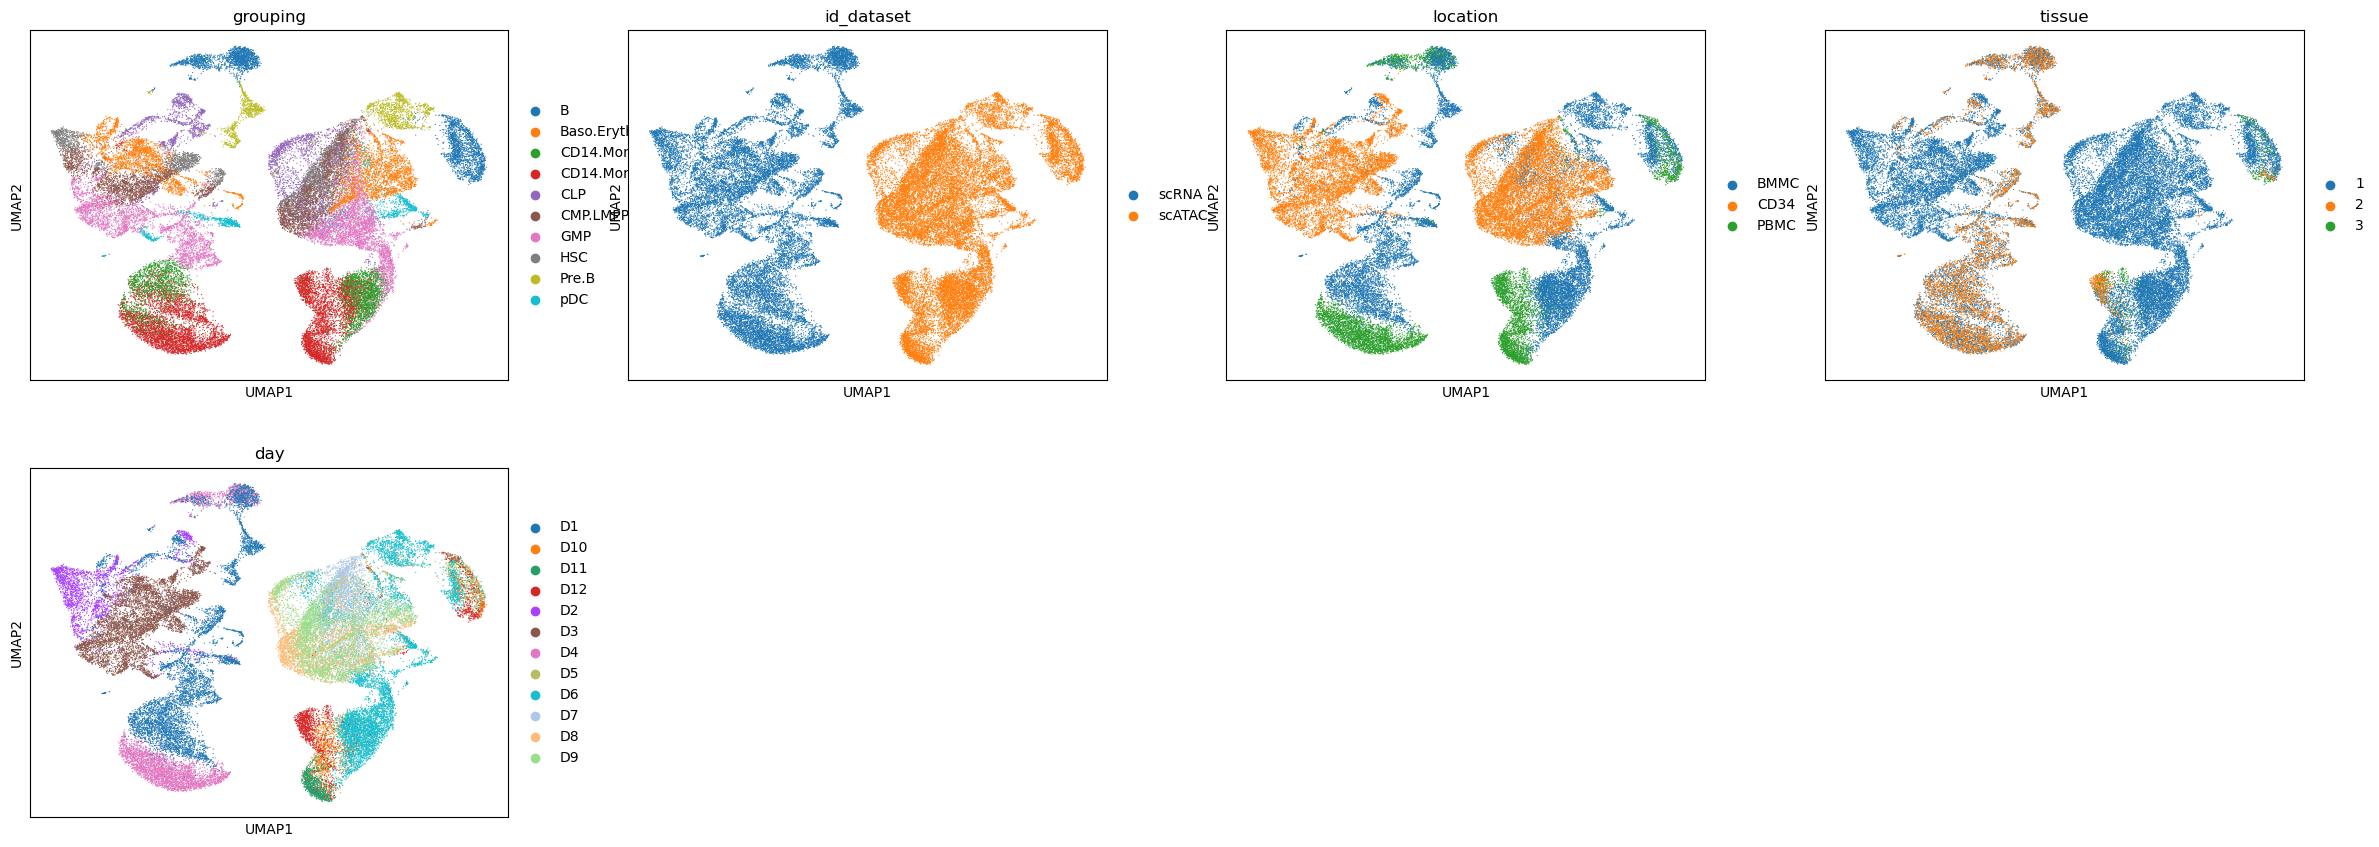

In [5]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['grouping', 'id_dataset', 'location', 'tissue', 'day'])

# Train VITAE model

Now we are able to run VITAE in several steps:

- Initialize VITAE model.
- Pretrain the autoencoder of VITAE model.
- Initialize the latent space of VITAE.
- Train the VITAE model.

## Initialization

In [6]:
reset_random_seeds(400)
tf.keras.backend.clear_session() 
model = VITAE.VITAE(adata = adata, covariates=['id_dataset'], conditions=cond,
                    model_type = 'Gaussian', 
                    npc=128, hidden_layers = [32,16], latent_space_dim=8)

2025-03-14 00:48:44.100120: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-14 00:48:44.123745: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-14 00:48:44.123855: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Pretrain

In the current stage, we only define the Autoencoder. The latent sturcture is still undefined. Before adding that, we'd better pretrain the Autoencoder to learn a better reprsentation $Z$ of $X$.

A large batch size will give a better and stable model, while it takes more memory to run. So if you are concerned about this, you could reduce the batch size.

In [7]:
model.pre_train(gamma=.6, phi=.6, early_stopping_tolerance = 0.01, early_stopping_relative=True)

# save the pretrain model for later use:
model.save_model(path_to_file="pretrained_model.checkpoint")

# load the pretrain model using the following command:
# model.load_model(path_to_file="pretrained_model.checkpoint")

2025-03-14 00:22:44.213222: I external/local_xla/xla/service/service.cc:168] XLA service 0x5ffb072a9b50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-03-14 00:22:44.213238: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-03-14 00:22:44.215341: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-03-14 00:22:44.223288: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1741911764.257583  362077 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 62/200 [========>.....................] - ETA: 29:33Best Epoch: 50. Best Metric: 99.721375.
Early stopping.
Pretrain Done.


Calculate UMAP ...


/home/jinhongd/anaconda3/envs/pyvitae/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/jinhongd/anaconda3/envs/pyvitae/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/jinhongd/anaconda3/envs/pyvitae/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categoric

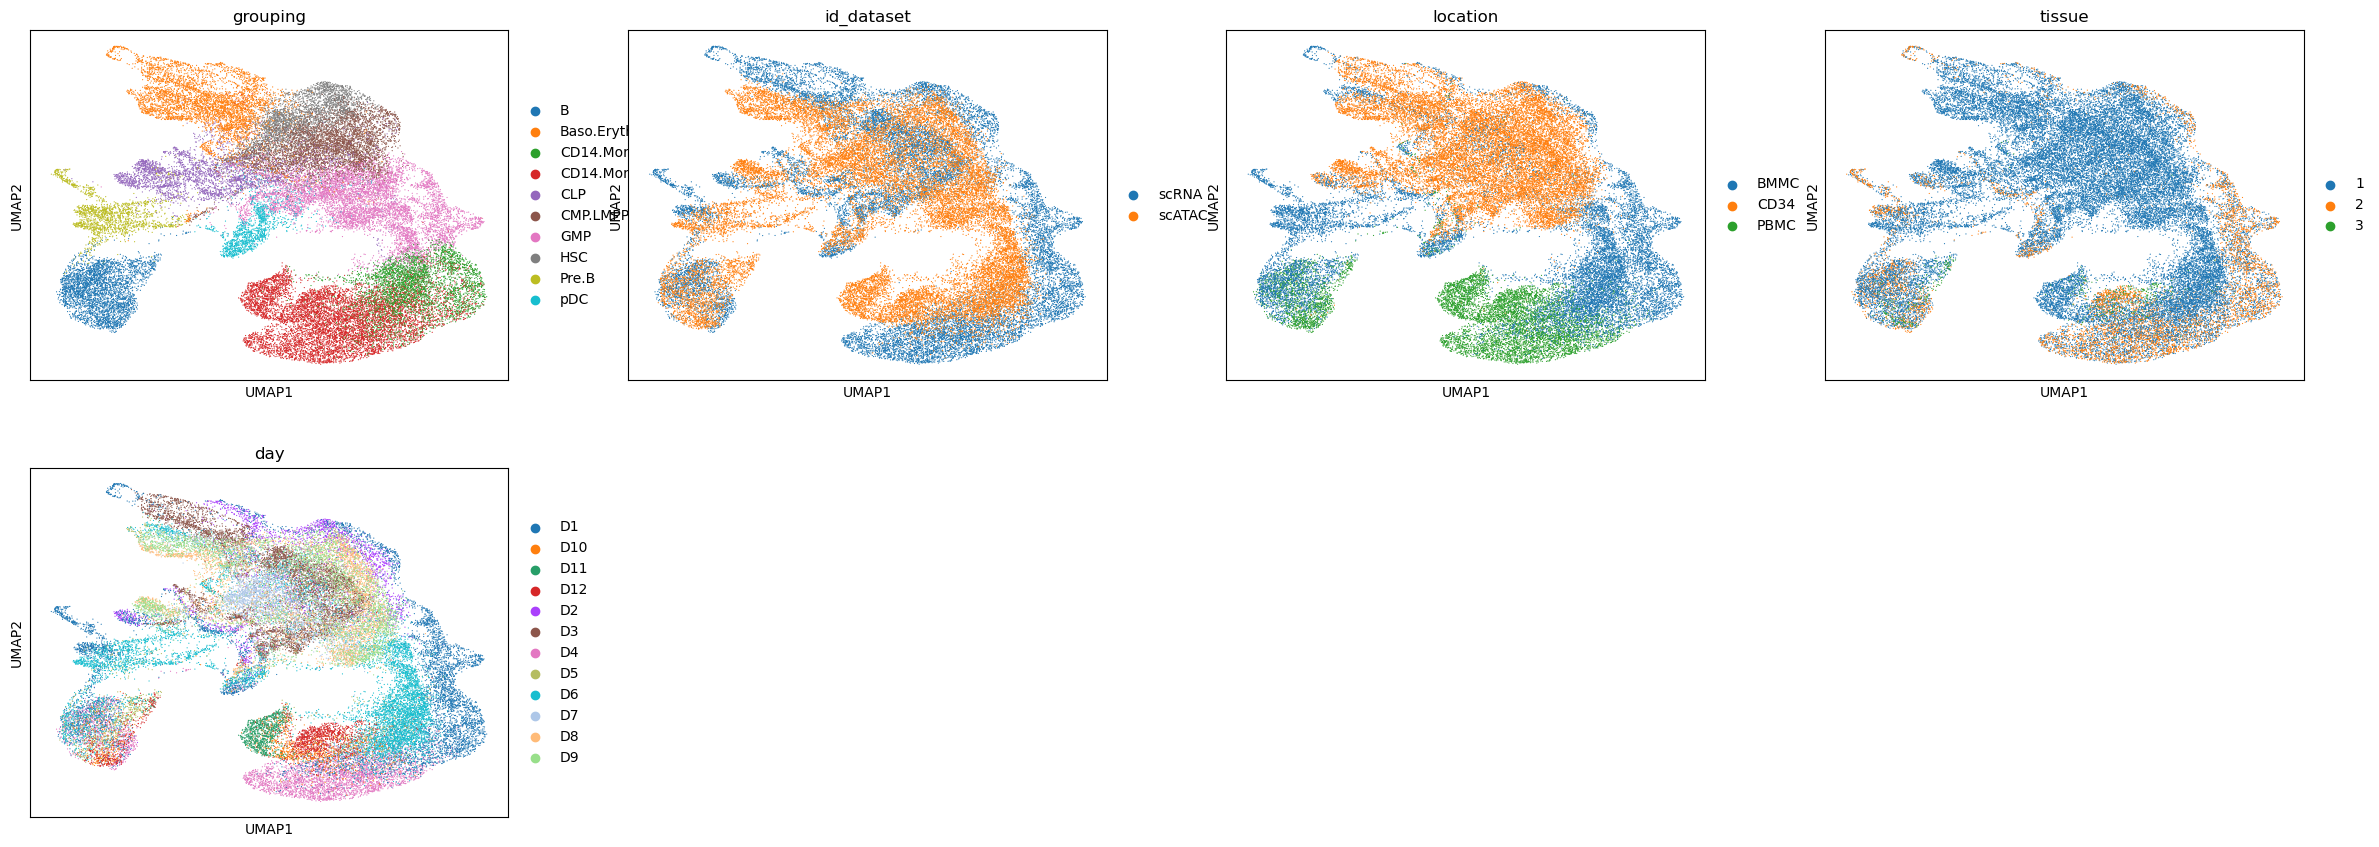

In [8]:
model.visualize_latent(color = ['grouping','id_dataset','location','tissue','day'], method = "UMAP")

## Initialize latent space

If you have information of the grouping/labels of cells, you are free to use them to initialze the latent structure, so that you will get better estimate and inference results, especially when the sample size is small or the classes are unbalanced.

Here, we compute the distance between clusters based on the 2D UMAP coordinates of cells, and use the distance to initialize the latent space.
80% the edges are pruned to make the graph more sparse, and the top 2 neighbors of each clusters are kept to ensure connectivity.

In [9]:
from VITAE.utils import _comp_dist
# use UMAP to compute distance between groupings
dist = _comp_dist(model.adata.obsm['X_umap'], model.adata.obs['grouping'].values)
model.init_latent_space(cluster_label='grouping', ratio_prune=0.8, topk=2, dist=dist)

Initial clustering labels saved as 'vitae_init_clustering' in self.adata.obs.


Below, we can visualize the initialized prior on the nodes and edges of the graph, where the weights for the nodes and the active edges are assigned uniformly.

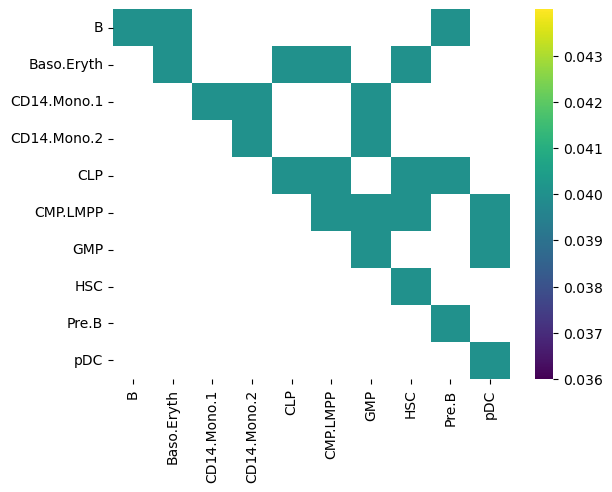

In [10]:
import seaborn as sns
row_names = col_names = np.unique(model.labels_map['label_names'])
sns.heatmap(model.pi, cmap='viridis', xticklabels=col_names, yticklabels=row_names, mask=(model.pi == 0))
plt.show()

/home/jinhongd/anaconda3/envs/pyvitae/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/jinhongd/anaconda3/envs/pyvitae/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/jinhongd/anaconda3/envs/pyvitae/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categoric

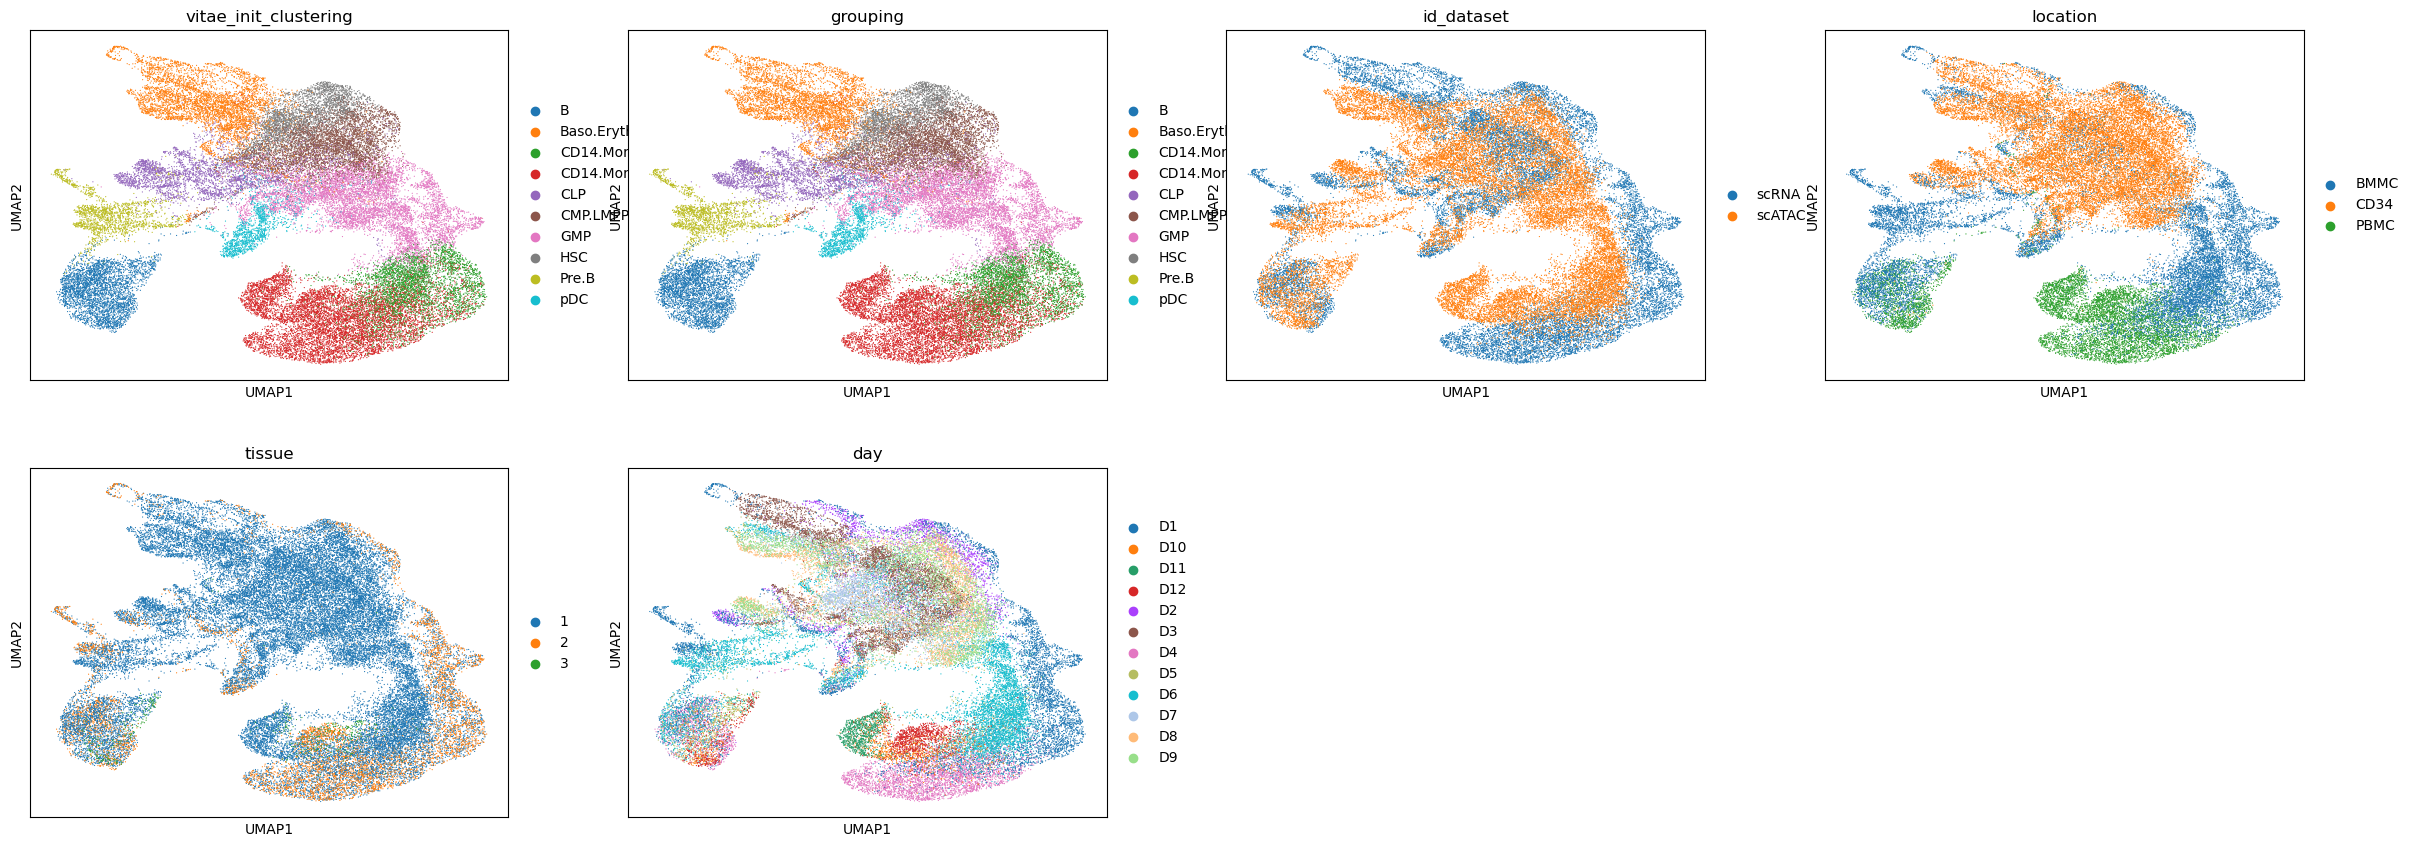

In [11]:
model.visualize_latent(color = ['vitae_init_clustering', 'grouping','id_dataset','location','tissue','day'], method = "UMAP")

## Train VITAE

In [12]:
model.train(gamma=1., phi=1., early_stopping_tolerance = 0.01, early_stopping_relative=True)

Warmup:0


2025-03-14 00:53:00.681241: I external/local_xla/xla/service/service.cc:168] XLA service 0x636df14adc90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-03-14 00:53:00.681259: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-03-14 00:53:00.683838: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-03-14 00:53:00.691644: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1741913580.732259  389632 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 36/200 [====>.........................] - ETA: 38:12Best Epoch: 25. Best Metric: 110.444527.
Early stopping.
Training Done!


# Inference

## Trajectory and Pseudotime

In [13]:
model.posterior_estimation()

Computing posterior estimations over mini-batches.


1313/1313 [==============================] - 4s 3ms/step
New clustering labels saved as 'vitae_new_clustering' in self.adata.obs.


Calculate UMAP ...


/home/jinhongd/anaconda3/envs/pyvitae/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/jinhongd/anaconda3/envs/pyvitae/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/jinhongd/anaconda3/envs/pyvitae/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categoric

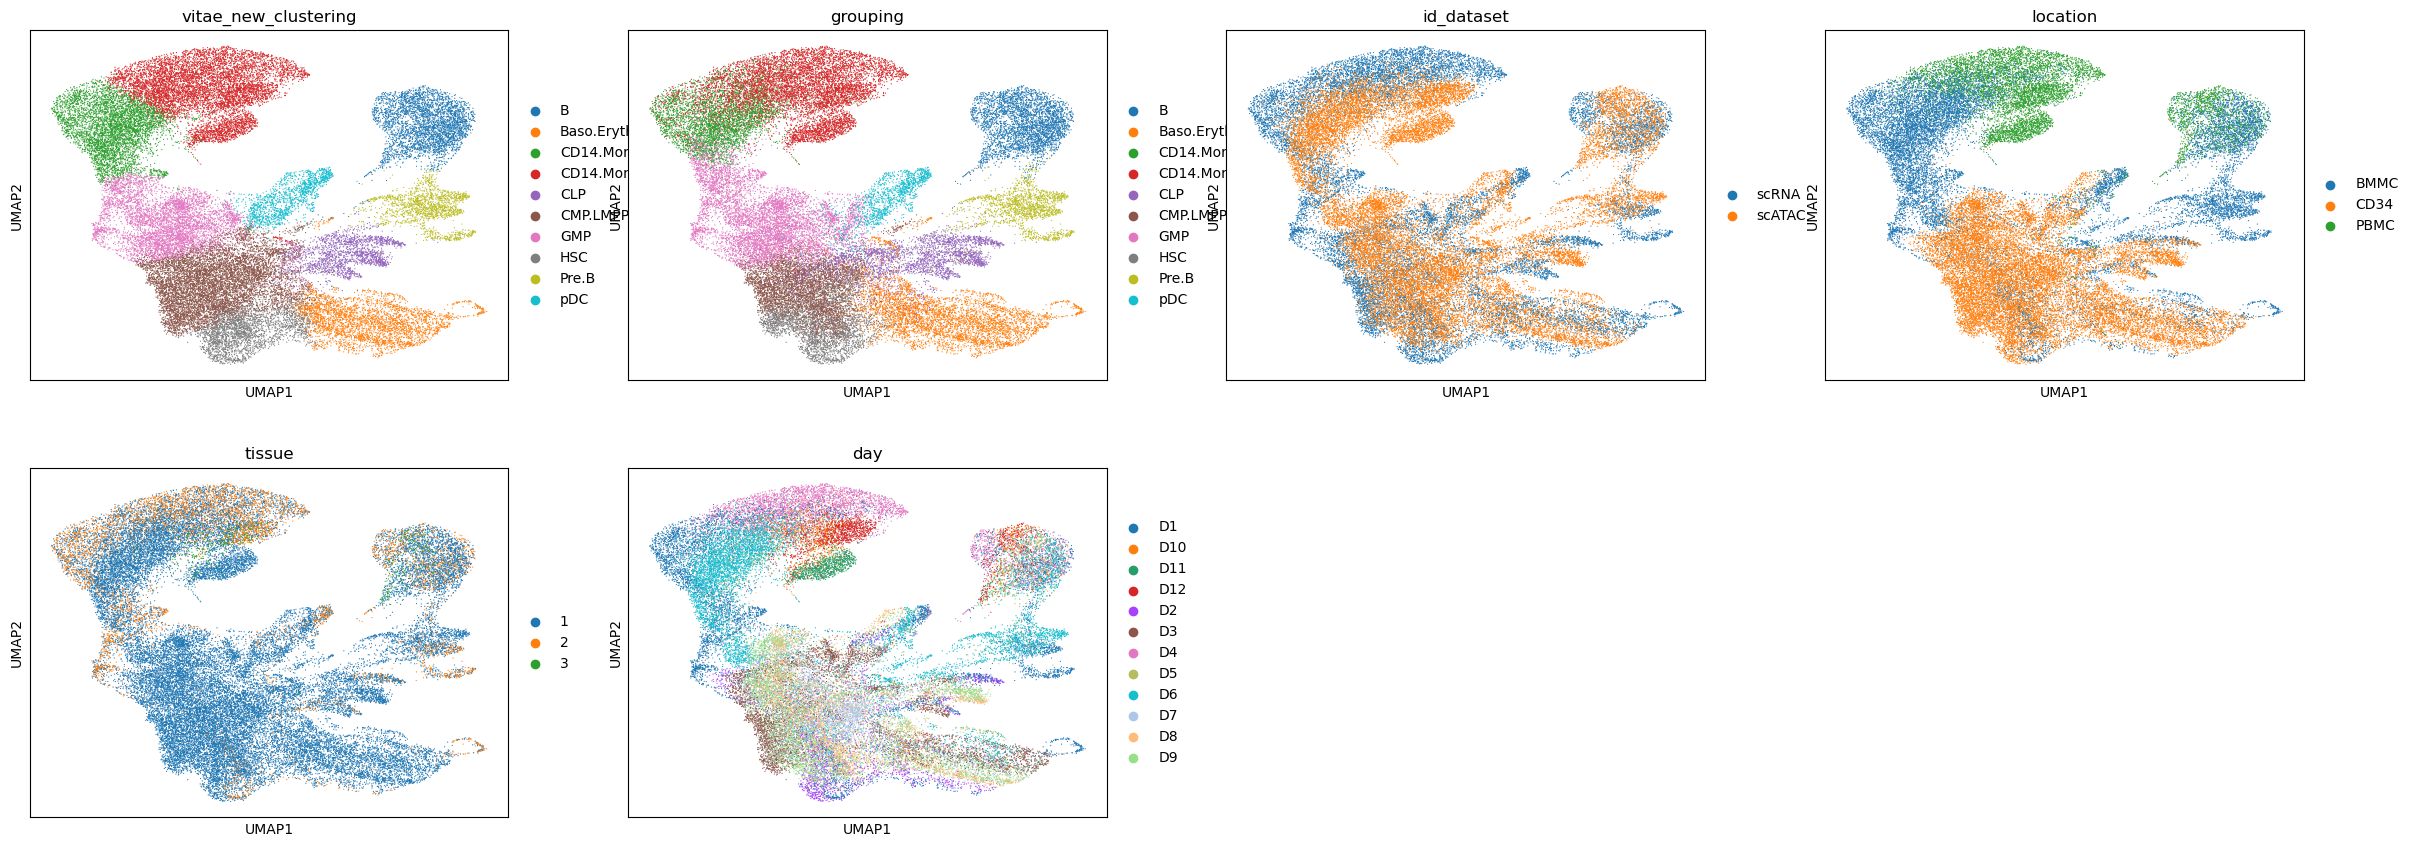

In [14]:
model.visualize_latent(color = ['vitae_new_clustering','grouping','id_dataset','location','tissue','day'], method = "UMAP")

Next, we provide the initial node 5 for the trajectory.

'vitae_new_clustering' updated based on the projected cell positions.
Cell projection uncertainties stored as 'projection_uncertainty' in self.adata.obs


/home/jinhongd/anaconda3/envs/pyvitae/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/jinhongd/anaconda3/envs/pyvitae/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/jinhongd/anaconda3/envs/pyvitae/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categoric

<Axes: title={'center': 'grouping'}, xlabel='UMAP1', ylabel='UMAP2'>

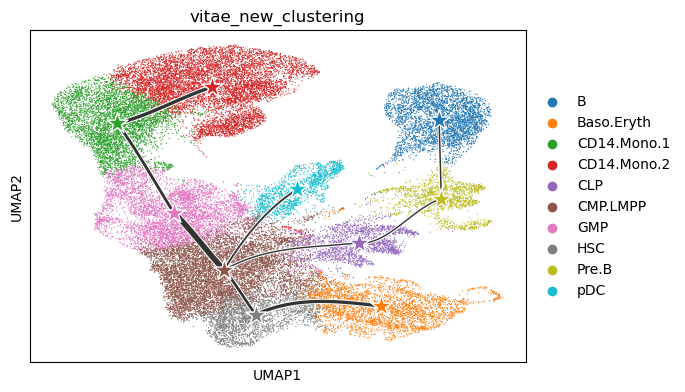

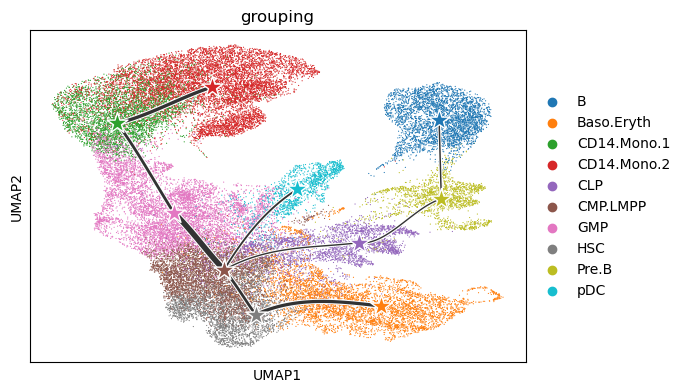

In [15]:
model.infer_backbone(method = "raw_map")
model.plot_backbone(color='grouping')

Next, we provide the initial node 'HSC' for the trajectory.

Cell projection uncertainties stored as 'pseudotime' in self.adata.obs


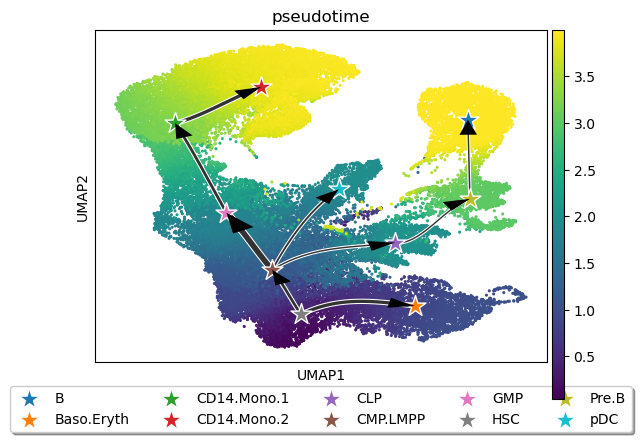

In [16]:
model.infer_trajectory('HSC', size=20, cmap='viridis')